# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 1024

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

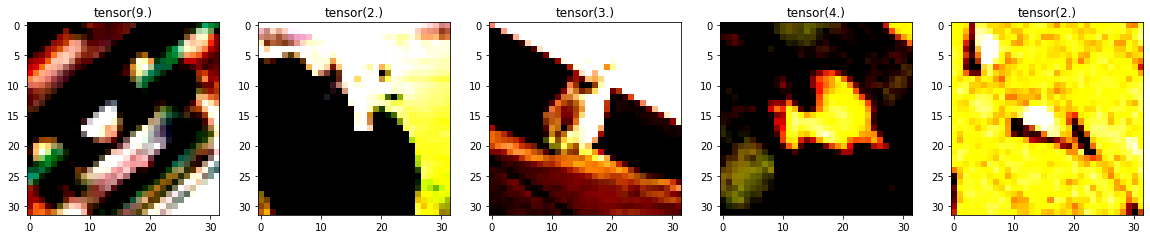

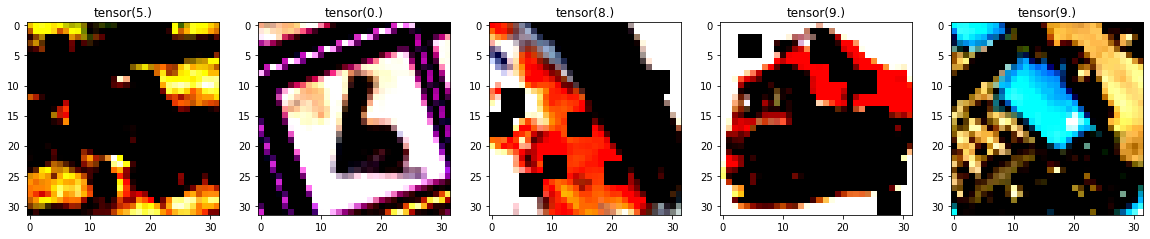

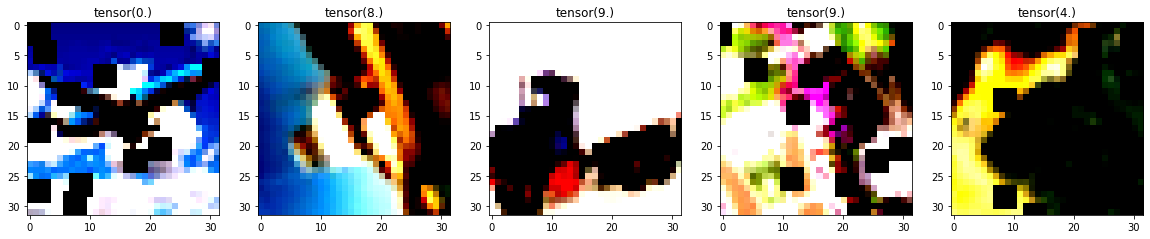

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d, PGConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = PGConv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, wbits=k, abits=k, pred_bits=k-1)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = PGConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, wbits=k, abits=k, pred_bits=k-1)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    PGConv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False, wbits=k, abits=k, pred_bits=k-1),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.k = K

        self.conv1 = PGConv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False, abits=8, wbits=8, pred_bits=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = QuantizedLinear(64, num_classes, abits=8, wbits=8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 3, 3], K=k)

In [10]:
net = resnet20(8)

bit width: 8


# Train with quantization

In [ ]:
from timm.scheduler import CosineLRScheduler

for k in range(4,9):
    net = resnet20(k=k)

    model = net.cuda()
    mixup = False

    # Track experiment with wandb
    import wandb
    watermark = "resnet20_pgquantize_k{}".format(k)

    # mess with wandb
    wandb.init(project="quantize_resnet", name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # optimizer for pact
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 4


wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin


current lr 1.00000e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/40]	Time 4.323 (4.323)	Data 1.608 (1.608)	Loss 3.1868 (3.1868)	Prec@1 11.426 (11.426)
Test: [0/10]	Time 1.516 (1.516)	Loss 2.7886 (2.7886)	Prec@1 13.184 (13.184)
 * Prec@1 12.740
alpha1 9.999961853027344
Best prec1 :  12.739999961853027
current lr 3.34000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [1][0/40]	Time 3.321 (3.321)	Data 1.809 (1.809)	Loss 3.1600 (3.1600)	Prec@1 11.426 (11.426)
Test: [0/10]	Time 1.165 (1.165)	Loss 2.0657 (2.0657)	Prec@1 24.316 (24.316)
 * Prec@1 22.640
alpha1 9.986610412597656
Best prec1 :  22.640000012207032
current lr 6.67000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [2][0/40]	Time 2.429 (2.429)	Data 1.460 (1.460)	Loss 2.3188 (2.3188)	Prec@1 21.289 (21.289)
Test: [0/10]	Time 1.966 (1.966)	Loss 1.8322 (1.8322)	Prec@1 31.250 (31.250)
 * Prec@1 31.920
alpha1 9.959967613220215
Best prec1 :  31.91999995727539
current lr 1.00000e-03


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [3][0/40]	Time 2.256 (2.256)	Data 1.395 (1.395)	Loss 2.0782 (2.0782)	Prec@1 30.859 (30.859)
Test: [0/10]	Time 1.719 (1.719)	Loss 1.8577 (1.8577)	Prec@1 30.957 (30.957)
 * Prec@1 32.410
alpha1 9.920103073120117
Best prec1 :  32.41000001220703
current lr 9.99938e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [4][0/40]	Time 2.270 (2.270)	Data 1.159 (1.159)	Loss 2.0689 (2.0689)	Prec@1 30.371 (30.371)
Test: [0/10]	Time 1.985 (1.985)	Loss 1.7315 (1.7315)	Prec@1 33.887 (33.887)
 * Prec@1 36.810
alpha1 9.880339622497559
Best prec1 :  36.80999990234375
current lr 9.99754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [5][0/40]	Time 3.333 (3.333)	Data 1.841 (1.841)	Loss 1.9664 (1.9664)	Prec@1 35.254 (35.254)
Test: [0/10]	Time 1.489 (1.489)	Loss 1.6799 (1.6799)	Prec@1 38.574 (38.574)
 * Prec@1 39.210
alpha1 9.840672492980957
Best prec1 :  39.210000079345704
current lr 9.99445e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [6][0/40]	Time 2.615 (2.615)	Data 1.205 (1.205)	Loss 1.9580 (1.9580)	Prec@1 35.840 (35.840)
Test: [0/10]	Time 1.884 (1.884)	Loss 1.6074 (1.6074)	Prec@1 40.039 (40.039)
 * Prec@1 41.780
alpha1 9.801104545593262
Best prec1 :  41.779999951171874
current lr 9.99014e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [7][0/40]	Time 3.451 (3.451)	Data 1.817 (1.817)	Loss 1.9228 (1.9228)	Prec@1 35.156 (35.156)
Test: [0/10]	Time 1.241 (1.241)	Loss 1.5780 (1.5780)	Prec@1 43.164 (43.164)
 * Prec@1 44.050
alpha1 9.761632919311523
Best prec1 :  44.04999989013672
current lr 9.98460e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [8][0/40]	Time 2.766 (2.766)	Data 1.415 (1.415)	Loss 1.8345 (1.8345)	Prec@1 38.770 (38.770)
Test: [0/10]	Time 1.674 (1.674)	Loss 1.6206 (1.6206)	Prec@1 39.258 (39.258)
 * Prec@1 42.380
alpha1 9.722261428833008
Best prec1 :  44.04999989013672
current lr 9.97783e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [9][0/40]	Time 2.318 (2.318)	Data 1.292 (1.292)	Loss 1.8380 (1.8380)	Prec@1 42.871 (42.871)
Test: [0/10]	Time 1.746 (1.746)	Loss 1.5082 (1.5082)	Prec@1 43.457 (43.457)
 * Prec@1 46.350
alpha1 9.682992935180664
Best prec1 :  46.35000003051758
current lr 9.96983e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [10][0/40]	Time 4.071 (4.071)	Data 2.239 (2.239)	Loss 1.8155 (1.8155)	Prec@1 41.113 (41.113)
Test: [0/10]	Time 1.186 (1.186)	Loss 1.4530 (1.4530)	Prec@1 48.340 (48.340)
 * Prec@1 47.730
alpha1 9.643830299377441
Best prec1 :  47.72999989013672
current lr 9.96061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [11][0/40]	Time 2.475 (2.475)	Data 1.572 (1.572)	Loss 1.7712 (1.7712)	Prec@1 45.215 (45.215)
Test: [0/10]	Time 2.264 (2.264)	Loss 1.3770 (1.3770)	Prec@1 50.781 (50.781)
 * Prec@1 50.670
alpha1 9.604776382446289
Best prec1 :  50.669999963378906
current lr 9.95017e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [12][0/40]	Time 3.720 (3.720)	Data 2.467 (2.467)	Loss 1.7787 (1.7787)	Prec@1 42.480 (42.480)
Test: [0/10]	Time 1.409 (1.409)	Loss 1.3874 (1.3874)	Prec@1 49.805 (49.805)
 * Prec@1 50.160
alpha1 9.565834045410156
Best prec1 :  50.669999963378906
current lr 9.93850e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [13][0/40]	Time 2.461 (2.461)	Data 1.569 (1.569)	Loss 1.7047 (1.7047)	Prec@1 43.750 (43.750)
Test: [0/10]	Time 2.035 (2.035)	Loss 1.3544 (1.3544)	Prec@1 49.609 (49.609)
 * Prec@1 51.630
alpha1 9.527007102966309
Best prec1 :  51.629999835205076
current lr 9.92562e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [14][0/40]	Time 3.989 (3.989)	Data 2.229 (2.229)	Loss 1.6466 (1.6466)	Prec@1 48.242 (48.242)
Test: [0/10]	Time 1.442 (1.442)	Loss 1.3308 (1.3308)	Prec@1 52.930 (52.930)
 * Prec@1 52.780
alpha1 9.488299369812012
Best prec1 :  52.78000001220703
current lr 9.91152e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [15][0/40]	Time 2.402 (2.402)	Data 1.465 (1.465)	Loss 1.6451 (1.6451)	Prec@1 47.070 (47.070)
Test: [0/10]	Time 2.049 (2.049)	Loss 1.3893 (1.3893)	Prec@1 49.023 (49.023)
 * Prec@1 49.990
alpha1 9.449712753295898
Best prec1 :  52.78000001220703
current lr 9.89622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [16][0/40]	Time 3.745 (3.745)	Data 2.559 (2.559)	Loss 1.6305 (1.6305)	Prec@1 47.168 (47.168)
Test: [0/10]	Time 1.547 (1.547)	Loss 1.3189 (1.3189)	Prec@1 51.953 (51.953)
 * Prec@1 52.300
alpha1 9.411249160766602
Best prec1 :  52.78000001220703
current lr 9.87970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [17][0/40]	Time 2.953 (2.953)	Data 1.452 (1.452)	Loss 1.6282 (1.6282)	Prec@1 47.168 (47.168)
Test: [0/10]	Time 1.928 (1.928)	Loss 1.2728 (1.2728)	Prec@1 53.809 (53.809)
 * Prec@1 53.610
alpha1 9.372915267944336
Best prec1 :  53.60999982910156
current lr 9.86199e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [18][0/40]	Time 3.316 (3.316)	Data 1.928 (1.928)	Loss 1.6166 (1.6166)	Prec@1 48.535 (48.535)
Test: [0/10]	Time 1.513 (1.513)	Loss 1.2556 (1.2556)	Prec@1 54.102 (54.102)
 * Prec@1 54.670
alpha1 9.334712028503418
Best prec1 :  54.669999951171874
current lr 9.84307e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [19][0/40]	Time 2.375 (2.375)	Data 1.237 (1.237)	Loss 1.5871 (1.5871)	Prec@1 48.145 (48.145)
Test: [0/10]	Time 1.941 (1.941)	Loss 1.2054 (1.2054)	Prec@1 56.738 (56.738)
 * Prec@1 55.990
alpha1 9.296646118164062
Best prec1 :  55.989999835205076
current lr 9.82296e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [20][0/40]	Time 3.793 (3.793)	Data 2.109 (2.109)	Loss 1.5744 (1.5744)	Prec@1 48.145 (48.145)
Test: [0/10]	Time 1.378 (1.378)	Loss 1.2051 (1.2051)	Prec@1 56.348 (56.348)
 * Prec@1 56.280
alpha1 9.25871467590332
Best prec1 :  56.27999993896484
current lr 9.80167e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [21][0/40]	Time 2.481 (2.481)	Data 1.389 (1.389)	Loss 1.5849 (1.5849)	Prec@1 48.730 (48.730)
Test: [0/10]	Time 1.868 (1.868)	Loss 1.1926 (1.1926)	Prec@1 57.324 (57.324)
 * Prec@1 57.280
alpha1 9.220929145812988
Best prec1 :  57.28000009765625
current lr 9.77919e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [22][0/40]	Time 2.913 (2.913)	Data 1.478 (1.478)	Loss 1.5695 (1.5695)	Prec@1 49.121 (49.121)
Test: [0/10]	Time 1.560 (1.560)	Loss 1.1868 (1.1868)	Prec@1 56.641 (56.641)
 * Prec@1 56.870
alpha1 9.183290481567383
Best prec1 :  57.28000009765625
current lr 9.75553e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [23][0/40]	Time 2.831 (2.831)	Data 1.355 (1.355)	Loss 1.5127 (1.5127)	Prec@1 51.172 (51.172)
Test: [0/10]	Time 1.762 (1.762)	Loss 1.1919 (1.1919)	Prec@1 58.008 (58.008)
 * Prec@1 56.890
alpha1 9.145798683166504
Best prec1 :  57.28000009765625
current lr 9.73070e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [24][0/40]	Time 3.926 (3.926)	Data 2.043 (2.043)	Loss 1.5652 (1.5652)	Prec@1 48.438 (48.438)
Test: [0/10]	Time 1.397 (1.397)	Loss 1.2119 (1.2119)	Prec@1 56.445 (56.445)
 * Prec@1 55.830
alpha1 9.108458518981934
Best prec1 :  57.28000009765625
current lr 9.70470e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [25][0/40]	Time 2.273 (2.273)	Data 1.420 (1.420)	Loss 1.5206 (1.5206)	Prec@1 51.953 (51.953)
Test: [0/10]	Time 2.251 (2.251)	Loss 1.1864 (1.1864)	Prec@1 55.273 (55.273)
 * Prec@1 56.920
alpha1 9.071272850036621
Best prec1 :  57.28000009765625
current lr 9.67754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [26][0/40]	Time 4.545 (4.545)	Data 1.953 (1.953)	Loss 1.5929 (1.5929)	Prec@1 49.219 (49.219)
Test: [0/10]	Time 1.989 (1.989)	Loss 1.1863 (1.1863)	Prec@1 56.543 (56.543)
 * Prec@1 57.330
alpha1 9.034245491027832
Best prec1 :  57.32999984741211
current lr 9.64923e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [27][0/40]	Time 3.991 (3.991)	Data 1.510 (1.510)	Loss 1.5311 (1.5311)	Prec@1 50.391 (50.391)
Test: [0/10]	Time 1.850 (1.850)	Loss 1.1508 (1.1508)	Prec@1 57.715 (57.715)
 * Prec@1 56.980
alpha1 8.997376441955566
Best prec1 :  57.32999984741211
current lr 9.61978e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [28][0/40]	Time 3.426 (3.426)	Data 1.240 (1.240)	Loss 1.4693 (1.4693)	Prec@1 53.320 (53.320)
Test: [0/10]	Time 2.164 (2.164)	Loss 1.1502 (1.1502)	Prec@1 58.105 (58.105)
 * Prec@1 58.100
alpha1 8.960668563842773
Best prec1 :  58.09999998779297
current lr 9.58918e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [29][0/40]	Time 4.337 (4.337)	Data 2.288 (2.288)	Loss 1.4688 (1.4688)	Prec@1 52.637 (52.637)
Test: [0/10]	Time 1.759 (1.759)	Loss 1.1092 (1.1092)	Prec@1 59.766 (59.766)
 * Prec@1 59.320
alpha1 8.92413330078125
Best prec1 :  59.32000000610351
current lr 9.55746e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [30][0/40]	Time 3.737 (3.737)	Data 1.549 (1.549)	Loss 1.4789 (1.4789)	Prec@1 52.051 (52.051)
Test: [0/10]	Time 2.223 (2.223)	Loss 1.1704 (1.1704)	Prec@1 57.910 (57.910)
 * Prec@1 56.800
alpha1 8.887763977050781
Best prec1 :  59.32000000610351
current lr 9.52461e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [31][0/40]	Time 5.035 (5.035)	Data 2.324 (2.324)	Loss 1.5283 (1.5283)	Prec@1 50.781 (50.781)
Test: [0/10]	Time 2.003 (2.003)	Loss 1.1250 (1.1250)	Prec@1 59.473 (59.473)
 * Prec@1 59.180
alpha1 8.851572036743164
Best prec1 :  59.32000000610351
current lr 9.49065e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [32][0/40]	Time 3.546 (3.546)	Data 1.317 (1.317)	Loss 1.4945 (1.4945)	Prec@1 50.586 (50.586)
Test: [0/10]	Time 2.614 (2.614)	Loss 1.1043 (1.1043)	Prec@1 61.035 (61.035)
 * Prec@1 60.040
alpha1 8.8155517578125
Best prec1 :  60.0399998046875
current lr 9.45558e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [33][0/40]	Time 3.448 (3.448)	Data 1.446 (1.446)	Loss 1.4203 (1.4203)	Prec@1 53.516 (53.516)
Test: [0/10]	Time 2.142 (2.142)	Loss 1.1181 (1.1181)	Prec@1 59.277 (59.277)
 * Prec@1 59.150
alpha1 8.779711723327637
Best prec1 :  60.0399998046875
current lr 9.41941e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [34][0/40]	Time 3.813 (3.813)	Data 1.550 (1.550)	Loss 1.4936 (1.4936)	Prec@1 52.148 (52.148)
Test: [0/10]	Time 1.884 (1.884)	Loss 1.0870 (1.0870)	Prec@1 59.668 (59.668)
 * Prec@1 60.560
alpha1 8.744054794311523
Best prec1 :  60.55999990844727
current lr 9.38215e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [35][0/40]	Time 3.107 (3.107)	Data 1.660 (1.660)	Loss 1.4069 (1.4069)	Prec@1 55.469 (55.469)
Test: [0/10]	Time 2.200 (2.200)	Loss 1.0769 (1.0769)	Prec@1 61.230 (61.230)
 * Prec@1 59.990
alpha1 8.708582878112793
Best prec1 :  60.55999990844727
current lr 9.34381e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [36][0/40]	Time 5.122 (5.122)	Data 2.471 (2.471)	Loss 1.3962 (1.3962)	Prec@1 55.664 (55.664)
Test: [0/10]	Time 1.820 (1.820)	Loss 1.0247 (1.0247)	Prec@1 63.281 (63.281)
 * Prec@1 61.620
alpha1 8.673295974731445
Best prec1 :  61.61999984130859
current lr 9.30441e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [37][0/40]	Time 3.579 (3.579)	Data 1.380 (1.380)	Loss 1.3699 (1.3699)	Prec@1 55.762 (55.762)
Test: [0/10]	Time 2.607 (2.607)	Loss 1.0022 (1.0022)	Prec@1 64.258 (64.258)
 * Prec@1 62.440
alpha1 8.638197898864746
Best prec1 :  62.4400000793457
current lr 9.26394e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [38][0/40]	Time 4.131 (4.131)	Data 1.841 (1.841)	Loss 1.4058 (1.4058)	Prec@1 57.031 (57.031)
Test: [0/10]	Time 2.049 (2.049)	Loss 1.0262 (1.0262)	Prec@1 63.477 (63.477)
 * Prec@1 62.230
alpha1 8.603294372558594
Best prec1 :  62.4400000793457
current lr 9.22242e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [39][0/40]	Time 3.704 (3.704)	Data 1.473 (1.473)	Loss 1.3894 (1.3894)	Prec@1 54.980 (54.980)
Test: [0/10]	Time 1.807 (1.807)	Loss 1.0256 (1.0256)	Prec@1 62.891 (62.891)
 * Prec@1 62.150
alpha1 8.568586349487305
Best prec1 :  62.4400000793457
current lr 9.17986e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [40][0/40]	Time 2.947 (2.947)	Data 1.172 (1.172)	Loss 1.3800 (1.3800)	Prec@1 56.055 (56.055)
Test: [0/10]	Time 2.139 (2.139)	Loss 0.9748 (0.9748)	Prec@1 64.355 (64.355)
 * Prec@1 63.050
alpha1 8.534075736999512
Best prec1 :  63.05000014648437
current lr 9.13627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [41][0/40]	Time 5.213 (5.213)	Data 2.806 (2.806)	Loss 1.4492 (1.4492)	Prec@1 54.199 (54.199)
Test: [0/10]	Time 3.223 (3.223)	Loss 1.0427 (1.0427)	Prec@1 61.914 (61.914)
 * Prec@1 62.600
alpha1 8.49976634979248
Best prec1 :  63.05000014648437
current lr 9.09166e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [42][0/40]	Time 3.527 (3.527)	Data 1.791 (1.791)	Loss 1.3090 (1.3090)	Prec@1 58.105 (58.105)
Test: [0/10]	Time 2.155 (2.155)	Loss 0.9883 (0.9883)	Prec@1 65.820 (65.820)
 * Prec@1 64.230
alpha1 8.46566104888916
Best prec1 :  64.22999974365234
current lr 9.04604e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [43][0/40]	Time 3.920 (3.920)	Data 1.456 (1.456)	Loss 1.3629 (1.3629)	Prec@1 57.422 (57.422)
Test: [0/10]	Time 2.210 (2.210)	Loss 0.9783 (0.9783)	Prec@1 65.137 (65.137)
 * Prec@1 64.090
alpha1 8.43175983428955
Best prec1 :  64.22999974365234
current lr 8.99942e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [44][0/40]	Time 3.214 (3.214)	Data 1.335 (1.335)	Loss 1.3393 (1.3393)	Prec@1 57.324 (57.324)
Test: [0/10]	Time 2.156 (2.156)	Loss 0.9862 (0.9862)	Prec@1 64.355 (64.355)
 * Prec@1 64.080
alpha1 8.398069381713867
Best prec1 :  64.22999974365234
current lr 8.95182e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [45][0/40]	Time 4.164 (4.164)	Data 1.674 (1.674)	Loss 1.3036 (1.3036)	Prec@1 60.254 (60.254)
Test: [0/10]	Time 1.737 (1.737)	Loss 0.9901 (0.9901)	Prec@1 65.527 (65.527)
 * Prec@1 64.870
alpha1 8.364585876464844
Best prec1 :  64.87000020751952
current lr 8.90325e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [46][0/40]	Time 3.397 (3.397)	Data 1.258 (1.258)	Loss 1.3254 (1.3254)	Prec@1 56.445 (56.445)
Test: [0/10]	Time 2.172 (2.172)	Loss 0.9433 (0.9433)	Prec@1 65.332 (65.332)
 * Prec@1 64.880
alpha1 8.331320762634277
Best prec1 :  64.88000008544923
current lr 8.85371e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [47][0/40]	Time 4.864 (4.864)	Data 2.362 (2.362)	Loss 1.4095 (1.4095)	Prec@1 54.883 (54.883)
Test: [0/10]	Time 1.824 (1.824)	Loss 0.9428 (0.9428)	Prec@1 66.797 (66.797)
 * Prec@1 64.760
alpha1 8.29826831817627
Best prec1 :  64.88000008544923
current lr 8.80323e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [48][0/40]	Time 3.557 (3.557)	Data 1.293 (1.293)	Loss 1.3338 (1.3338)	Prec@1 56.641 (56.641)
Test: [0/10]	Time 2.428 (2.428)	Loss 0.9389 (0.9389)	Prec@1 66.504 (66.504)
 * Prec@1 65.990
alpha1 8.265429496765137
Best prec1 :  65.9900001586914
current lr 8.75180e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [49][0/40]	Time 3.472 (3.472)	Data 1.635 (1.635)	Loss 1.2920 (1.2920)	Prec@1 57.422 (57.422)
Test: [0/10]	Time 2.101 (2.101)	Loss 0.9513 (0.9513)	Prec@1 65.234 (65.234)
 * Prec@1 64.460
alpha1 8.232813835144043
Best prec1 :  65.9900001586914
current lr 8.69946e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [50][0/40]	Time 3.990 (3.990)	Data 1.612 (1.612)	Loss 1.3185 (1.3185)	Prec@1 57.617 (57.617)
Test: [0/10]	Time 1.937 (1.937)	Loss 0.9339 (0.9339)	Prec@1 66.406 (66.406)
 * Prec@1 64.890
alpha1 8.20042610168457
Best prec1 :  65.9900001586914
current lr 8.64620e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [51][0/40]	Time 3.421 (3.421)	Data 1.228 (1.228)	Loss 1.2642 (1.2642)	Prec@1 60.352 (60.352)
Test: [0/10]	Time 2.143 (2.143)	Loss 0.9221 (0.9221)	Prec@1 69.043 (69.043)
 * Prec@1 65.880
alpha1 8.168262481689453
Best prec1 :  65.9900001586914
current lr 8.59204e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [52][0/40]	Time 3.957 (3.957)	Data 2.049 (2.049)	Loss 1.3109 (1.3109)	Prec@1 58.105 (58.105)
Test: [0/10]	Time 2.129 (2.129)	Loss 0.9648 (0.9648)	Prec@1 65.625 (65.625)
 * Prec@1 65.410
alpha1 8.136324882507324
Best prec1 :  65.9900001586914
current lr 8.53700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [53][0/40]	Time 4.183 (4.183)	Data 1.706 (1.706)	Loss 1.2887 (1.2887)	Prec@1 58.789 (58.789)
Test: [0/10]	Time 2.523 (2.523)	Loss 0.9051 (0.9051)	Prec@1 67.773 (67.773)
 * Prec@1 66.890
alpha1 8.104616165161133
Best prec1 :  66.89000008544922
current lr 8.48108e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [54][0/40]	Time 4.062 (4.062)	Data 1.744 (1.744)	Loss 1.2702 (1.2702)	Prec@1 60.742 (60.742)
Test: [0/10]	Time 2.150 (2.150)	Loss 0.9018 (0.9018)	Prec@1 68.945 (68.945)
 * Prec@1 67.330
alpha1 8.073141098022461
Best prec1 :  67.33000006103515
current lr 8.42431e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [55][0/40]	Time 4.252 (4.252)	Data 1.733 (1.733)	Loss 1.2616 (1.2616)	Prec@1 59.375 (59.375)
Test: [0/10]	Time 1.986 (1.986)	Loss 0.9034 (0.9034)	Prec@1 67.383 (67.383)
 * Prec@1 66.300
alpha1 8.041898727416992
Best prec1 :  67.33000006103515
current lr 8.36670e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [56][0/40]	Time 3.234 (3.234)	Data 1.381 (1.381)	Loss 1.2849 (1.2849)	Prec@1 58.203 (58.203)
Test: [0/10]	Time 2.186 (2.186)	Loss 0.8874 (0.8874)	Prec@1 68.066 (68.066)
 * Prec@1 66.450
alpha1 8.010885238647461
Best prec1 :  67.33000006103515
current lr 8.30825e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [57][0/40]	Time 4.962 (4.962)	Data 2.457 (2.457)	Loss 1.2344 (1.2344)	Prec@1 60.547 (60.547)
Test: [0/10]	Time 1.942 (1.942)	Loss 0.9140 (0.9140)	Prec@1 67.969 (67.969)
 * Prec@1 66.230
alpha1 7.980109214782715
Best prec1 :  67.33000006103515
current lr 8.24899e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [58][0/40]	Time 3.446 (3.446)	Data 1.409 (1.409)	Loss 1.2978 (1.2978)	Prec@1 61.133 (61.133)
Test: [0/10]	Time 2.647 (2.647)	Loss 0.8676 (0.8676)	Prec@1 68.750 (68.750)
 * Prec@1 67.630
alpha1 7.9495720863342285
Best prec1 :  67.62999968261718
current lr 8.18893e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [59][0/40]	Time 4.394 (4.394)	Data 1.874 (1.874)	Loss 1.2151 (1.2151)	Prec@1 59.180 (59.180)
Test: [0/10]	Time 1.973 (1.973)	Loss 0.8694 (0.8694)	Prec@1 68.262 (68.262)
 * Prec@1 67.350
alpha1 7.919276237487793
Best prec1 :  67.62999968261718
current lr 8.12809e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [60][0/40]	Time 3.402 (3.402)	Data 1.195 (1.195)	Loss 1.2845 (1.2845)	Prec@1 58.496 (58.496)
Test: [0/10]	Time 2.193 (2.193)	Loss 0.8679 (0.8679)	Prec@1 69.531 (69.531)
 * Prec@1 67.830
alpha1 7.889222621917725
Best prec1 :  67.82999978027344
current lr 8.06647e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [61][0/40]	Time 4.078 (4.078)	Data 1.777 (1.777)	Loss 1.2449 (1.2449)	Prec@1 59.863 (59.863)
Test: [0/10]	Time 2.090 (2.090)	Loss 0.9219 (0.9219)	Prec@1 68.066 (68.066)
 * Prec@1 66.400
alpha1 7.859412670135498
Best prec1 :  67.82999978027344
current lr 8.00410e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [62][0/40]	Time 3.645 (3.645)	Data 1.394 (1.394)	Loss 1.1632 (1.1632)	Prec@1 61.914 (61.914)
Test: [0/10]	Time 2.527 (2.527)	Loss 0.9062 (0.9062)	Prec@1 68.457 (68.457)
 * Prec@1 67.170
alpha1 7.829848766326904
Best prec1 :  67.82999978027344
current lr 7.94099e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [63][0/40]	Time 3.672 (3.672)	Data 1.679 (1.679)	Loss 1.2497 (1.2497)	Prec@1 59.570 (59.570)
Test: [0/10]	Time 2.044 (2.044)	Loss 0.8989 (0.8989)	Prec@1 67.578 (67.578)
 * Prec@1 67.490
alpha1 7.800532817840576
Best prec1 :  67.82999978027344
current lr 7.87715e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [64][0/40]	Time 4.081 (4.081)	Data 1.747 (1.747)	Loss 1.2130 (1.2130)	Prec@1 60.352 (60.352)
Test: [0/10]	Time 2.265 (2.265)	Loss 0.9012 (0.9012)	Prec@1 68.066 (68.066)
 * Prec@1 68.190
alpha1 7.771466255187988
Best prec1 :  68.18999981689453
current lr 7.81261e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [65][0/40]	Time 3.486 (3.486)	Data 1.642 (1.642)	Loss 1.2246 (1.2246)	Prec@1 61.816 (61.816)
Test: [0/10]	Time 2.238 (2.238)	Loss 0.8562 (0.8562)	Prec@1 68.359 (68.359)
 * Prec@1 68.460
alpha1 7.742652416229248
Best prec1 :  68.45999981689454
current lr 7.74737e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [66][0/40]	Time 4.453 (4.453)	Data 1.859 (1.859)	Loss 1.2241 (1.2241)	Prec@1 61.816 (61.816)
Test: [0/10]	Time 2.170 (2.170)	Loss 0.9038 (0.9038)	Prec@1 67.090 (67.090)
 * Prec@1 67.350
alpha1 7.714094638824463
Best prec1 :  68.45999981689454
current lr 7.68145e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [67][0/40]	Time 3.227 (3.227)	Data 1.424 (1.424)	Loss 1.1878 (1.1878)	Prec@1 62.109 (62.109)
Test: [0/10]	Time 2.109 (2.109)	Loss 0.8648 (0.8648)	Prec@1 69.629 (69.629)
 * Prec@1 68.970
alpha1 7.685789585113525
Best prec1 :  68.97000009765625
current lr 7.61488e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [68][0/40]	Time 3.547 (3.547)	Data 1.505 (1.505)	Loss 1.1664 (1.1664)	Prec@1 60.938 (60.938)
Test: [0/10]	Time 2.051 (2.051)	Loss 0.8870 (0.8870)	Prec@1 68.164 (68.164)
 * Prec@1 67.980
alpha1 7.657740116119385
Best prec1 :  68.97000009765625
current lr 7.54766e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [69][0/40]	Time 3.496 (3.496)	Data 1.634 (1.634)	Loss 1.1690 (1.1690)	Prec@1 61.328 (61.328)
Test: [0/10]	Time 2.111 (2.111)	Loss 0.8488 (0.8488)	Prec@1 68.066 (68.066)
 * Prec@1 68.420
alpha1 7.629950046539307
Best prec1 :  68.97000009765625
current lr 7.47982e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [70][0/40]	Time 3.916 (3.916)	Data 1.537 (1.537)	Loss 1.1995 (1.1995)	Prec@1 63.574 (63.574)
Test: [0/10]	Time 1.994 (1.994)	Loss 0.8221 (0.8221)	Prec@1 71.191 (71.191)
 * Prec@1 69.680
alpha1 7.602419376373291
Best prec1 :  69.67999993896484
current lr 7.41136e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [71][0/40]	Time 3.140 (3.140)	Data 1.360 (1.360)	Loss 1.2108 (1.2108)	Prec@1 60.547 (60.547)
Test: [0/10]	Time 2.132 (2.132)	Loss 0.8379 (0.8379)	Prec@1 70.996 (70.996)
 * Prec@1 69.610
alpha1 7.575144290924072
Best prec1 :  69.67999993896484
current lr 7.34231e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [72][0/40]	Time 4.574 (4.574)	Data 2.284 (2.284)	Loss 1.1897 (1.1897)	Prec@1 63.086 (63.086)
Test: [0/10]	Time 2.069 (2.069)	Loss 0.8697 (0.8697)	Prec@1 70.312 (70.312)
 * Prec@1 68.020
alpha1 7.548136234283447
Best prec1 :  69.67999993896484
current lr 7.27268e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [73][0/40]	Time 3.239 (3.239)	Data 1.200 (1.200)	Loss 1.1694 (1.1694)	Prec@1 63.086 (63.086)
Test: [0/10]	Time 2.142 (2.142)	Loss 0.8335 (0.8335)	Prec@1 71.094 (71.094)
 * Prec@1 69.350
alpha1 7.521395206451416
Best prec1 :  69.67999993896484
current lr 7.20250e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [74][0/40]	Time 3.869 (3.869)	Data 1.927 (1.927)	Loss 1.1658 (1.1658)	Prec@1 63.379 (63.379)
Test: [0/10]	Time 1.978 (1.978)	Loss 0.8051 (0.8051)	Prec@1 70.801 (70.801)
 * Prec@1 69.890
alpha1 7.4949188232421875
Best prec1 :  69.88999997558594
current lr 7.13177e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [75][0/40]	Time 3.518 (3.518)	Data 1.477 (1.477)	Loss 1.2055 (1.2055)	Prec@1 63.672 (63.672)
Test: [0/10]	Time 2.120 (2.120)	Loss 0.8594 (0.8594)	Prec@1 69.629 (69.629)
 * Prec@1 69.250
alpha1 7.4687066078186035
Best prec1 :  69.88999997558594
current lr 7.06051e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [76][0/40]	Time 4.378 (4.378)	Data 1.869 (1.869)	Loss 1.2277 (1.2277)	Prec@1 61.035 (61.035)
Test: [0/10]	Time 2.018 (2.018)	Loss 0.8084 (0.8084)	Prec@1 70.801 (70.801)
 * Prec@1 70.580
alpha1 7.4427618980407715
Best prec1 :  70.57999986572266
current lr 6.98875e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [77][0/40]	Time 3.218 (3.218)	Data 1.383 (1.383)	Loss 1.1343 (1.1343)	Prec@1 64.941 (64.941)
Test: [0/10]	Time 2.205 (2.205)	Loss 0.8309 (0.8309)	Prec@1 70.996 (70.996)
 * Prec@1 70.150
alpha1 7.417088985443115
Best prec1 :  70.57999986572266
current lr 6.91650e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [78][0/40]	Time 4.793 (4.793)	Data 2.181 (2.181)	Loss 1.1619 (1.1619)	Prec@1 63.574 (63.574)
Test: [0/10]	Time 1.945 (1.945)	Loss 0.8399 (0.8399)	Prec@1 70.605 (70.605)
 * Prec@1 69.630
alpha1 7.391683101654053
Best prec1 :  70.57999986572266
current lr 6.84378e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [79][0/40]	Time 3.860 (3.860)	Data 1.834 (1.834)	Loss 1.1927 (1.1927)	Prec@1 61.328 (61.328)
Test: [0/10]	Time 2.156 (2.156)	Loss 0.8037 (0.8037)	Prec@1 72.852 (72.852)
 * Prec@1 70.910
alpha1 7.366544246673584
Best prec1 :  70.91000020751953
current lr 6.77061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [80][0/40]	Time 4.061 (4.061)	Data 1.585 (1.585)	Loss 1.2201 (1.2201)	Prec@1 61.523 (61.523)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv